# 08.5b: Black Hole Fission Detection

**Search for black hole fission events across 16 parallel training runs**

This notebook analyzes pre-computed black hole counts to detect fission events—the smoking gun: **an increase in the number of black holes**.

## Definitions

- **Black hole**: Two or more tokens with bit-identical embeddings
- **Population**: Number of tokens in a black hole (≥2 by definition)
- **Singleton**: A token with a unique embedding (population = 1)
- **Fission**: One black hole splitting into two or more black holes
- **Formation**: Two or more singletons spontaneously becoming bit-identical (expected to be extremely rare)
- **Offtokening**: A token transitioning from black hole member → neutron-star matter member
- **Emission**: A token ejected from a black hole, escaping to become an isolated singleton

## Detection Strategy

For each run:
1. Load pre-computed black hole counts
2. Identify steps where black hole count **increases**
3. Visualize evolution across all runs
4. Report aggregate statistics

## Data

- 16 runs × 10,001 steps × 128 tokens
- Total: 20,480,000 vector-steps of observation time
- Pre-computed: Black hole counts from 08.4d

## Parameters

In [31]:
# Data directories
DATA_DIR = "../data"
RUN_PATTERN = "embeddings_128vocab_qweninit_run_*"
COUNTS_FILE = "black_hole_counts.safetensors"

# Expected dimensions
EXPECTED_RUNS = 16
EXPECTED_STEPS = 10001
VOCAB_SIZE = 128

RANDOM_SEED = 42

## Imports

In [32]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Load All Runs

In [33]:
data_dir = Path(DATA_DIR)
run_dirs = sorted(data_dir.glob(RUN_PATTERN))

print(f"Found {len(run_dirs)} runs:")
for run_dir in run_dirs:
    print(f"  {run_dir.name}")

if len(run_dirs) != EXPECTED_RUNS:
    print(f"\n⚠ WARNING: Expected {EXPECTED_RUNS} runs, found {len(run_dirs)}")
else:
    print(f"\n✓ Found all {EXPECTED_RUNS} runs")

Found 16 runs:
  embeddings_128vocab_qweninit_run_001
  embeddings_128vocab_qweninit_run_002
  embeddings_128vocab_qweninit_run_003
  embeddings_128vocab_qweninit_run_004
  embeddings_128vocab_qweninit_run_005
  embeddings_128vocab_qweninit_run_006
  embeddings_128vocab_qweninit_run_007
  embeddings_128vocab_qweninit_run_008
  embeddings_128vocab_qweninit_run_009
  embeddings_128vocab_qweninit_run_010
  embeddings_128vocab_qweninit_run_011
  embeddings_128vocab_qweninit_run_012
  embeddings_128vocab_qweninit_run_013
  embeddings_128vocab_qweninit_run_014
  embeddings_128vocab_qweninit_run_015
  embeddings_128vocab_qweninit_run_016

✓ Found all 16 runs


## Load Black Hole Counts

In [34]:
black_hole_counts = {}  # run_name -> array of counts
black_hole_populations = {}  # run_name -> array of populations
largest_bh_sizes = {}  # run_name -> array of largest BH sizes

print(f"\nLoading black hole counts...\n")

for run_dir in tqdm(run_dirs, desc="Loading runs"):
    run_name = run_dir.name.split('_')[-1]
    counts_path = run_dir / COUNTS_FILE
    
    if not counts_path.exists():
        print(f"  ⚠ {run_name}: counts file not found, skipping")
        continue
    
    # Load counts
    data = load_file(counts_path)
    counts = data['counts'].numpy()
    populations = data['populations'].numpy()
    largest_bh = data['largest_bh_size'].numpy()
    
    # Validate shape
    if len(counts) != EXPECTED_STEPS:
        print(f"  ⚠ {run_name}: unexpected length {len(counts)}, skipping")
        continue
    
    black_hole_counts[run_name] = counts
    black_hole_populations[run_name] = populations
    largest_bh_sizes[run_name] = largest_bh

print(f"\n✓ Loaded {len(black_hole_counts)} runs")


Loading black hole counts...



Loading runs:   0%|          | 0/16 [00:00<?, ?it/s]


✓ Loaded 16 runs


## Detect Increases in Black Hole Count

In [35]:
# Find all steps where black hole count increased
fission_candidates = {}  # run_name -> list of (step, count_before, count_after)

total_increases = 0

for run_name, counts in black_hole_counts.items():
    increases = []
    
    for step in range(1, len(counts)):
        if counts[step] > counts[step - 1]:
            increases.append((step, counts[step - 1], counts[step]))
            total_increases += 1
    
    fission_candidates[run_name] = increases

print(f"{'='*80}")
print("FISSION CANDIDATE SUMMARY")
print(f"{'='*80}\n")

print(f"Total observation opportunities: {VOCAB_SIZE * EXPECTED_STEPS * len(black_hole_counts):,} vector-steps")
print(f"Total black hole count increases: {total_increases:,}\n")

if total_increases > 0:
    print(f"Runs with increases:")
    for run_name, increases in sorted(fission_candidates.items()):
        if increases:
            print(f"  {run_name}: {len(increases)} events")
            for step, before, after in increases[:5]:  # Show first 5
                print(f"    Step {step:5d}: {before} → {after} black holes (+{after - before})")
            if len(increases) > 5:
                print(f"    ... and {len(increases) - 5} more")
else:
    print("⚠ No black hole count increases detected in any run!")
    print("\nThis suggests:")
    print("  - Black hole fission is extremely rare (< 1 in 20 million vector-steps)")
    print("  - OR our detection threshold is too strict")
    print("  - The primordial black hole only evaporates, never splits")

print(f"\n{'='*80}")

FISSION CANDIDATE SUMMARY

Total observation opportunities: 20,482,048 vector-steps
Total black hole count increases: 95

Runs with increases:
  001: 10 events
    Step     1: 1 → 4 black holes (+3)
    Step     3: 3 → 7 black holes (+4)
    Step     5: 7 → 10 black holes (+3)
    Step     8: 7 → 9 black holes (+2)
    Step    11: 4 → 5 black holes (+1)
    ... and 5 more
  002: 8 events
    Step     1: 1 → 4 black holes (+3)
    Step     2: 4 → 7 black holes (+3)
    Step     4: 2 → 3 black holes (+1)
    Step     6: 2 → 3 black holes (+1)
    Step     8: 1 → 2 black holes (+1)
    ... and 3 more
  003: 8 events
    Step     1: 1 → 5 black holes (+4)
    Step     2: 5 → 6 black holes (+1)
    Step     4: 1 → 3 black holes (+2)
    Step     5: 3 → 5 black holes (+2)
    Step     8: 2 → 4 black holes (+2)
    ... and 3 more
  004: 6 events
    Step     1: 1 → 6 black holes (+5)
    Step     2: 6 → 7 black holes (+1)
    Step     7: 2 → 3 black holes (+1)
    Step    14: 2 → 3 black hole

## Visualize Black Hole Evolution

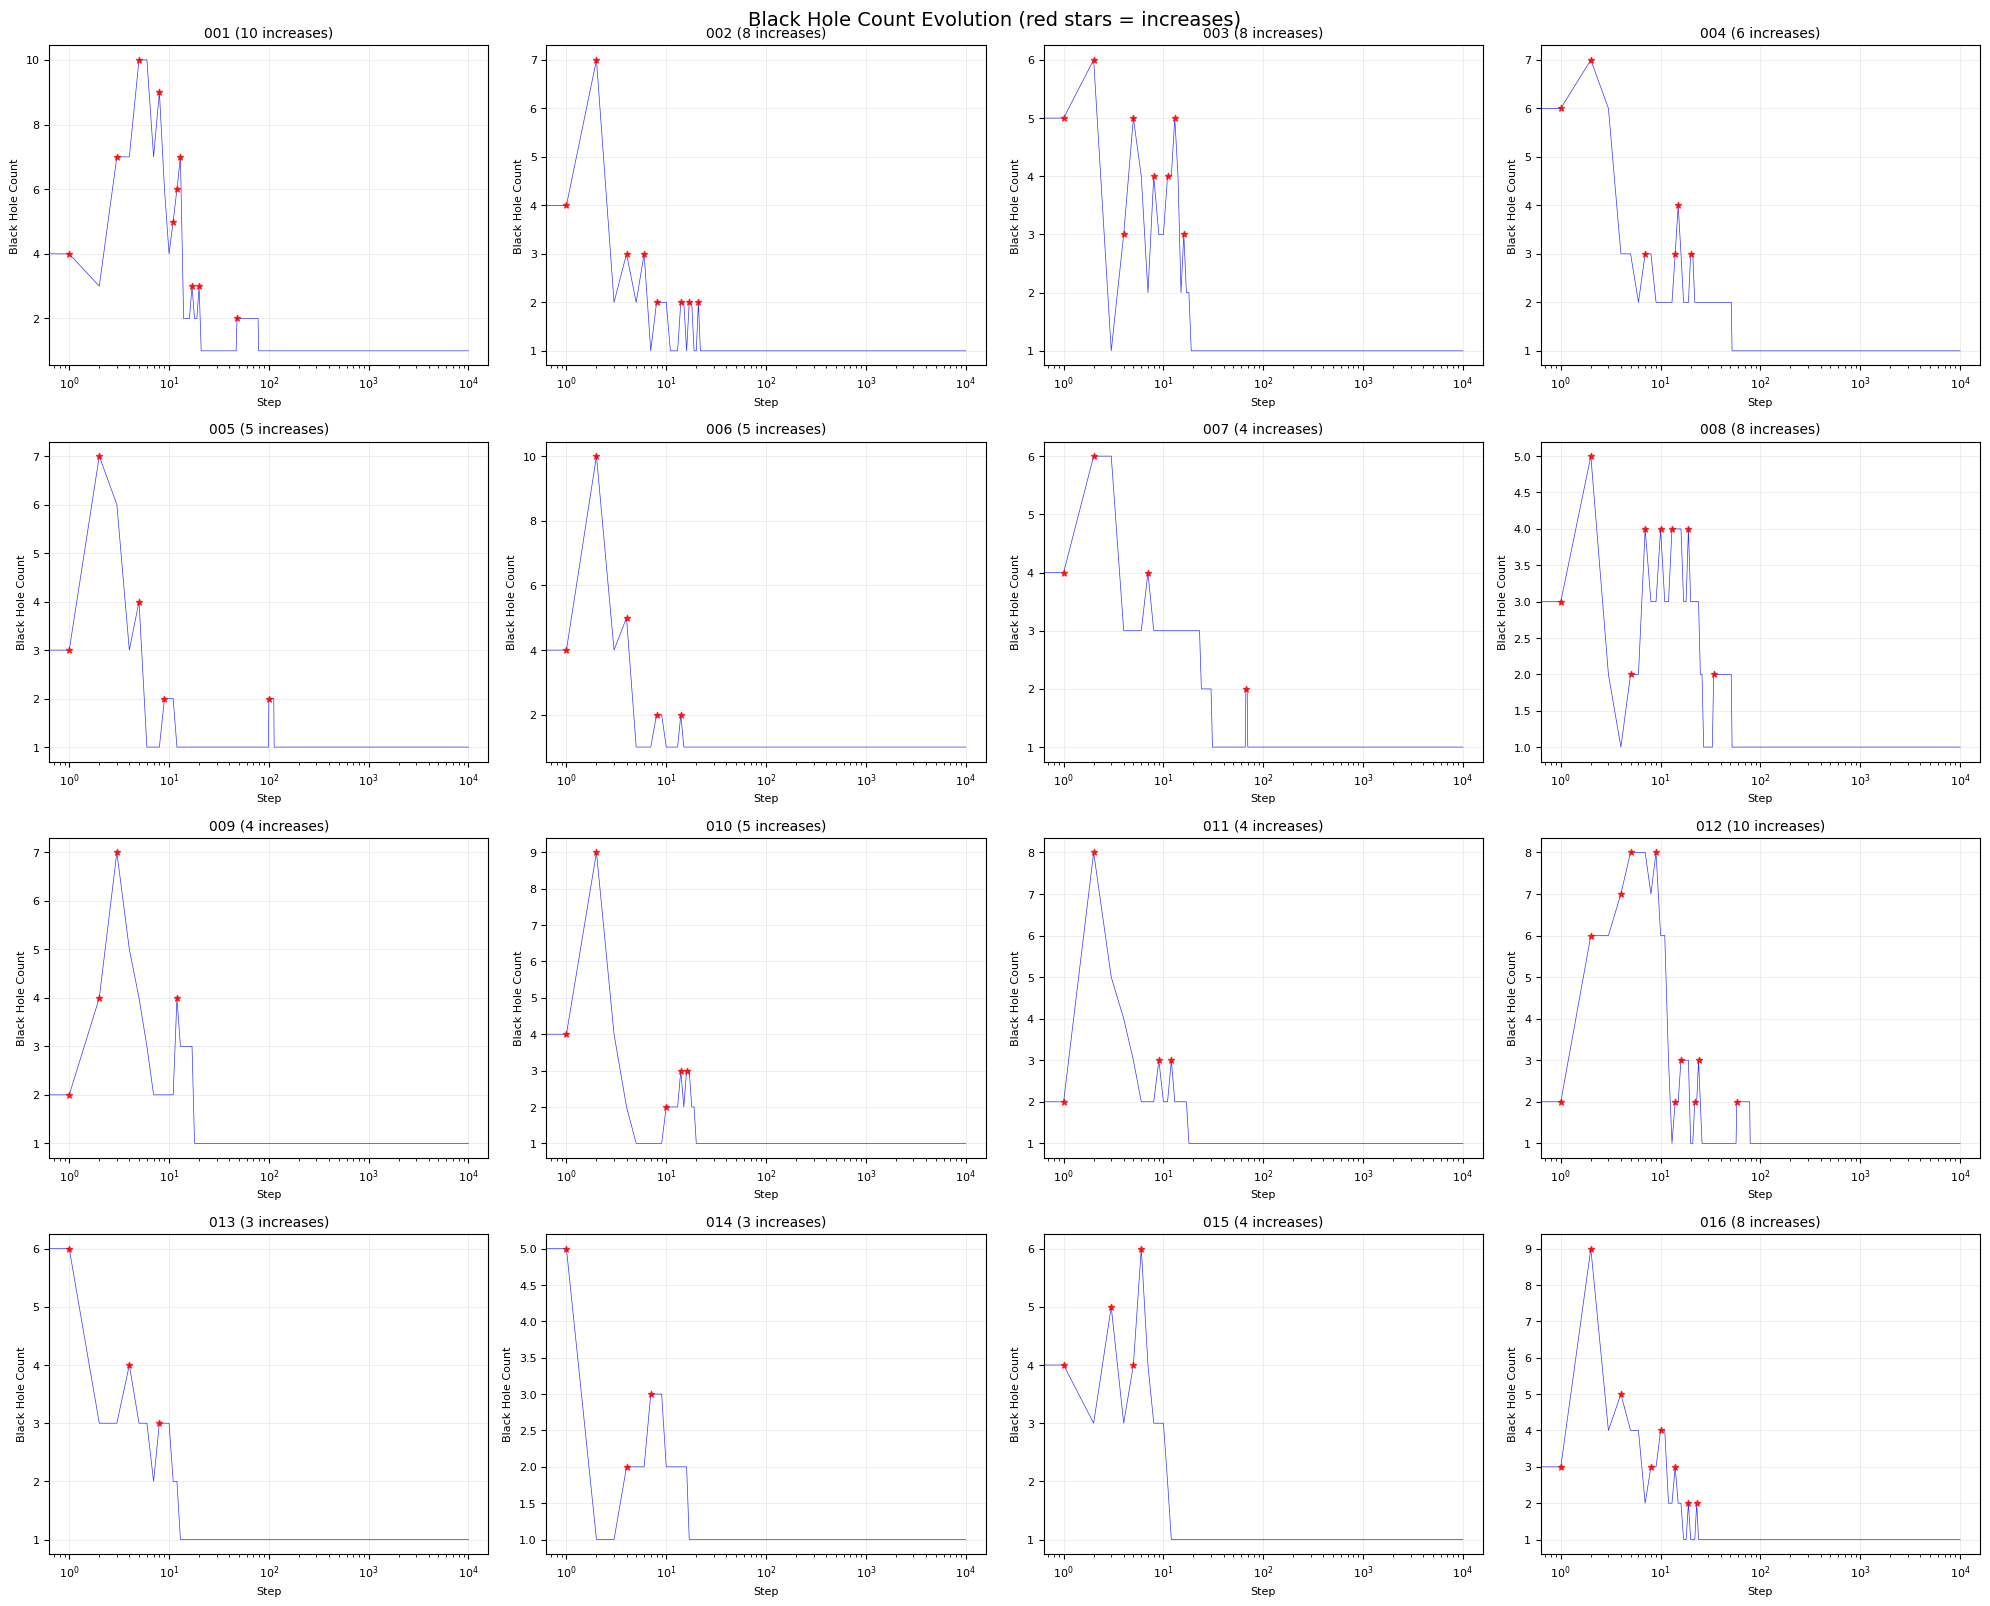

In [38]:
# Plot black hole count over time for all runs
fig, axes = plt.subplots(4, 4, figsize=(20, 16), dpi=100)
axes = axes.flatten()

for idx, (run_name, counts) in enumerate(sorted(black_hole_counts.items())):
    ax = axes[idx]
    
    # Plot count
    ax.plot(counts, linewidth=0.5, alpha=0.8, color='blue')
    
    # Mark increases with red dots
    increases = fission_candidates[run_name]
    if increases:
        increase_steps = [step for step, _, _ in increases]
        increase_counts = [counts[step] for step in increase_steps]
        ax.scatter(increase_steps, increase_counts, color='red', s=20, zorder=5, alpha=0.8, marker='*')
    
    ax.set_title(f"{run_name} ({len(increases)} increases)", fontsize=10)
    ax.set_xlabel("Step", fontsize=8)
    ax.set_xscale('log')
    ax.set_ylabel("Black Hole Count", fontsize=8)
    ax.grid(True, alpha=0.3, linewidth=0.5)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.suptitle("Black Hole Count Evolution (red stars = increases)", fontsize=14, y=1.001)
plt.show()

## Aggregate Statistics

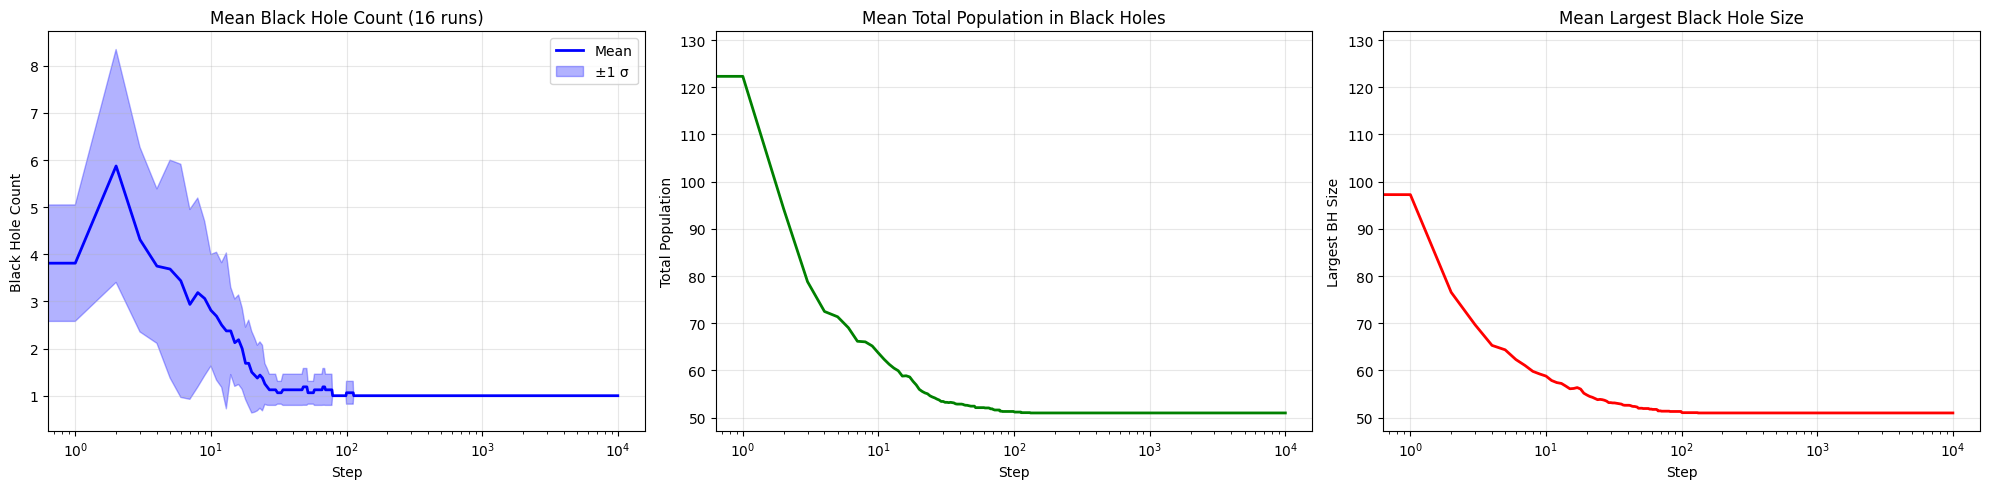


Aggregate statistics (mean across 16 runs):

Step 0 (initial singularity):
  Black hole count: 1.0 ± 0.0
  Population: 128.0
  Largest BH: 128.0

Step 10,000 (final):
  Black hole count: 1.0 ± 0.0
  Population: 51.0
  Largest BH: 51.0

Change:
  Black holes: +0.0
  Population: -77.0 tokens
  Largest BH: -77.0


In [39]:
# Compute aggregate statistics across all runs
all_counts = np.array([counts for counts in black_hole_counts.values()])
all_populations = np.array([pops for pops in black_hole_populations.values()])
all_largest = np.array([sizes for sizes in largest_bh_sizes.values()])

mean_counts = all_counts.mean(axis=0)
std_counts = all_counts.std(axis=0)
mean_populations = all_populations.mean(axis=0)
mean_largest = all_largest.mean(axis=0)

# Plot aggregate evolution
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

# Black hole count
ax1.plot(mean_counts, linewidth=2, label='Mean', color='blue')
ax1.fill_between(range(len(mean_counts)), 
                  mean_counts - std_counts, 
                  mean_counts + std_counts, 
                  alpha=0.3, color='blue', label='±1 σ')
ax1.set_xlabel("Step")
ax1.set_xscale('log')
ax1.set_ylabel("Black Hole Count")
ax1.set_title("Mean Black Hole Count (16 runs)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Total population in black holes
ax2.plot(mean_populations, linewidth=2, color='green')
ax2.set_xlabel("Step")
ax2.set_xscale('log')
ax2.set_ylabel("Total Population")
ax2.set_title("Mean Total Population in Black Holes")
ax2.grid(True, alpha=0.3)

# Largest black hole size
ax3.plot(mean_largest, linewidth=2, color='red')
ax3.set_xlabel("Step")
ax3.set_xscale('log')
ax3.set_ylabel("Largest BH Size")
ax3.set_title("Mean Largest Black Hole Size")
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nAggregate statistics (mean across {len(black_hole_counts)} runs):")
print(f"\nStep 0 (initial singularity):")
print(f"  Black hole count: {mean_counts[0]:.1f} ± {std_counts[0]:.1f}")
print(f"  Population: {mean_populations[0]:.1f}")
print(f"  Largest BH: {mean_largest[0]:.1f}")
print(f"\nStep 10,000 (final):")
print(f"  Black hole count: {mean_counts[-1]:.1f} ± {std_counts[-1]:.1f}")
print(f"  Population: {mean_populations[-1]:.1f}")
print(f"  Largest BH: {mean_largest[-1]:.1f}")
print(f"\nChange:")
print(f"  Black holes: {mean_counts[-1] - mean_counts[0]:+.1f}")
print(f"  Population: {mean_populations[-1] - mean_populations[0]:+.1f} tokens")
print(f"  Largest BH: {mean_largest[-1] - mean_largest[0]:+.1f}")

## Interpretation

Based on the results above:

### If black hole count increased:
- **Fission detected!** We observed black holes splitting
- This is direct evidence of quantization-driven dynamics in embedding space
- The mechanism: gradient descent + bfloat16 quantization noise breaks up dense clusters

### If black hole count stayed constant or decreased:
- **Only evaporation observed** (primordial black hole loses population)
- Fission is rarer than 1 in 20 million vector-steps
- This suggests: once tokens escape the singularity, they don't re-collapse into new black holes
- The dynamics favor dispersion over aggregation